# Pytorch PackedSequence tutorial


In [1]:
import torch
import torch.nn as nn
import numpy as np

## Contents

1.   Preprocessing
2.   How to use PackedsEquence object in pytorch



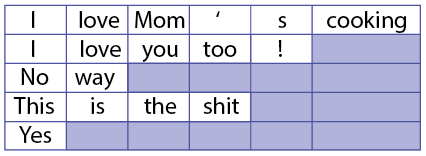

figure from: https://medium.com/huggingface/understanding-emotions-from-keras-to-pytorch-3ccb61d5a983

## 1. Preprocessing
Always have to do this processing, while you are working on NLP

*   make vocabulary, one token matches single unique index.
*   add
*   change all tokens to vocabulary index that you made.

In [10]:
np.random.seed(123)
batch_data = ["I love Mom ' s cooking", "I love you too !", "No way", "This is the shit", "Yes"]
input_seq = [s.split() for s in batch_data]
max_len = 0
for s in input_seq:
    if len(s) >= max_len:
        max_len = len(s)
vocab = {w: i for i, w in enumerate(set([t for s in input_seq for t in s]), 1)}
vocab["<pad>"] = 0
input_seq = [s+["<pad>"]*(max_len-len(s)) if len(s) < max_len else s for s in input_seq]
input_seq2idx = torch.LongTensor([list(map(vocab.get, s)) for s in input_seq])

In [12]:
input_seq

[['I', 'love', 'Mom', "'", 's', 'cooking'],
 ['I', 'love', 'you', 'too', '!', '<pad>'],
 ['No', 'way', '<pad>', '<pad>', '<pad>', '<pad>'],
 ['This', 'is', 'the', 'shit', '<pad>', '<pad>'],
 ['Yes', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']]

In [13]:
input_seq2idx

tensor([[12,  1,  8,  7,  9,  3],
        [12,  1, 15,  2, 13,  0],
        [16, 11,  0,  0,  0,  0],
        [ 6, 14,  4, 10,  0,  0],
        [ 5,  0,  0,  0,  0,  0]])

## 2. How to use PackedSequence object in pytorch

1.   using pack_padded_sequence
2.   ussage in RNN
3.   unpack to get output
4.   last hidden state mapped to output


### 2.1 using pack_padded_sequence

change batch matrix in a decreasing order of sententh length.

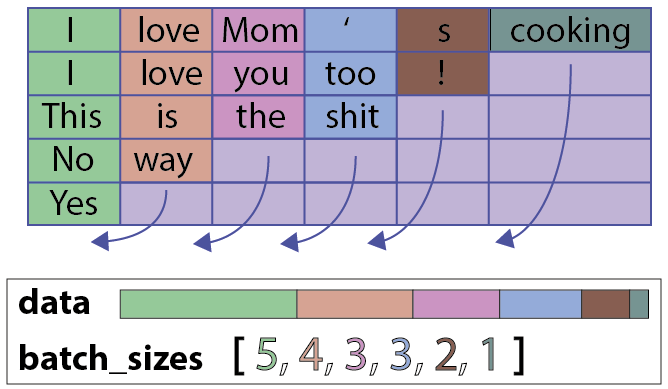

figure from: https://medium.com/huggingface/understanding-emotions-from-keras-to-pytorch-3ccb61d5a983

In [14]:
from torch.nn.utils.rnn import pack_padded_sequence

In [16]:
input_lengths = torch.LongTensor([torch.max(input_seq2idx[i, :].data.nonzero())+1  # 각 elements(row)를 index로 변환하기 전에 각 elements(row)에서 가장 큰 값을 가진 element의 index만 저장한다 / +1 한 것은 몇 번째 element인지 직관적으로 알아보기 위함?
                                  for i in range(input_seq2idx.size(0))])
input_lengths, sorted_idx = input_lengths.sort(0, descending = True)
input_seq2idx = input_seq2idx[sorted_idx]

In [17]:
input_seq2idx

tensor([[12,  1,  8,  7,  9,  3],
        [12,  1, 15,  2, 13,  0],
        [ 6, 14,  4, 10,  0,  0],
        [16, 11,  0,  0,  0,  0],
        [ 5,  0,  0,  0,  0,  0]])

In [27]:
input_lengths  #  length ofeach sentences in batch

tensor([6, 5, 4, 2, 1])

In [28]:
packed_input = pack_padded_sequence(input_seq2idx, input_lengths.tolist(), batch_first=True)

In [30]:
print(type(packed_input))
print(packed_input[0])  # packed data
print(packed_input[1])  # batch_size

<class 'torch.nn.utils.rnn.PackedSequence'>
tensor([12, 12,  6, 16,  5,  1,  1, 14, 11,  8, 15,  4,  7,  2, 10,  9, 13,  3])
tensor([5, 4, 3, 3, 2, 1])


### 2.2 usage in RNN

Any RNN type(RNN, LSTM, GRU) that you use it's not matter

Also, normaliy we use Embedding layer to map all tokens to a real number vector space. In training step, let the network learn the suitable space to solve task. if you don't familiar Embebdding layer search under references.



*   Pytorch documentation: https://pytorch.org/docs/stable/nn.html?highlight=embedding#torch.nn.Embedding
*   presented some picture how embedding works in my blog (korean) https://simonjisu.github.io/nlp/2018/04/20/allaboutwv2.html


In [31]:
vocab_size = len(vocab)
hidden_size = 1
embedding_size = 5
num_layers = 3

In [36]:
embed = nn.Embedding(vocab_size, embedding_size, padding_idx = 0)
gru = nn.RNN(input_size = embedding_size, hidden_size = hidden_size, num_layers = num_layers,
             bidirectional= False, batch_first = True)

In [37]:
embeded = embed(input_seq2idx)
packed_input = pack_padded_sequence(embeded, input_lengths.tolist(), batch_first=True)
packed_output, hidden = gru(packed_input)

In [38]:
packed_output[0].size(), packed_output[1]

(torch.Size([18, 1]), tensor([5, 4, 3, 3, 2, 1]))

### 2.3 unpack to get output

In [39]:
from torch.nn.utils.rnn import pad_packed_sequence

In [40]:
output, output_lengths = pad_packed_sequence(packed_output, batch_first = True)

In [42]:
output.size(), output_lengths

(torch.Size([5, 6, 1]), tensor([6, 5, 4, 2, 1]))

In [43]:
packed_output[0]

tensor([[-0.6900],
        [-0.6900],
        [-0.7499],
        [-0.4238],
        [-0.4229],
        [-0.5938],
        [-0.5938],
        [-0.5235],
        [-0.6676],
        [-0.5550],
        [-0.5929],
        [-0.7463],
        [-0.6618],
        [-0.7297],
        [-0.5064],
        [-0.4751],
        [-0.5038],
        [-0.7427]], grad_fn=<CatBackward>)

In [44]:
output

tensor([[[-0.6900],
         [-0.5938],
         [-0.5550],
         [-0.6618],
         [-0.4751],
         [-0.7427]],

        [[-0.6900],
         [-0.5938],
         [-0.5929],
         [-0.7297],
         [-0.5038],
         [ 0.0000]],

        [[-0.7499],
         [-0.5235],
         [-0.7463],
         [-0.5064],
         [ 0.0000],
         [ 0.0000]],

        [[-0.4238],
         [-0.6676],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]],

        [[-0.4229],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]]], grad_fn=<TransposeBackward0>)

### 2.4 last hidden state mapped to output

In [45]:
import pandas as pd

In [46]:
def color_white(val):
    color = 'white' if val == 0 else 'black'
    return 'color: {}'.format(color)
def color_red(data):
    max_len = len(data)
    fmt = 'color: red'
    lst = []
    for i, v in enumerate(data):
        if (v != 0) and (i == max_len-1):
            lst.append(fmt)
        elif (v != 0) and (data[i+1] == 0):
            lst.append(fmt)
        else:
            lst.append('')
    return lst

In [48]:
df = pd.DataFrame(np.concatenate([o.detach().numpy() for o in output.transpose(0, 1)], axis=1).round(4))
df.index.name = 'batch'
df.columns.name = 'hidden_step'
df.style.applymap(color_white).apply(color_red, axis=1)

hidden_step,0,1,2,3,4,5
batch,,,,,,
0,-0.690000,-0.593800,-0.555000,-0.661800,-0.475100,-0.742700
1,-0.690000,-0.593800,-0.592900,-0.729700,-0.503800,0.000000
2,-0.749900,-0.523500,-0.746300,-0.506400,0.000000,0.000000
3,-0.423800,-0.667600,0.000000,0.000000,0.000000,0.000000
4,-0.422900,0.000000,0.000000,0.000000,0.000000,0.000000


In [49]:
hidden[-1]

tensor([[-0.7427],
        [-0.5038],
        [-0.5064],
        [-0.6676],
        [-0.4229]], grad_fn=<SelectBackward>)

In [50]:
packed_output[0], packed_output[1]

(tensor([[-0.6900],
         [-0.6900],
         [-0.7499],
         [-0.4238],
         [-0.4229],
         [-0.5938],
         [-0.5938],
         [-0.5235],
         [-0.6676],
         [-0.5550],
         [-0.5929],
         [-0.7463],
         [-0.6618],
         [-0.7297],
         [-0.5064],
         [-0.4751],
         [-0.5038],
         [-0.7427]], grad_fn=<CatBackward>), tensor([5, 4, 3, 3, 2, 1]))

# Sequence lstm embedding

In [ ]:
#sentence = ("if you want to build a ship, don't drum up people together to "
#            "collect wood and don't assign them tasks and work, but rather "
#            "teach them to long for the endless immensity of the sea.")

In [ ]:
sentence = "Repeat is the best medicine for memory".split()

In [ ]:
vocab = list(set(sentence))
print(vocab)

['the', 'medicine', 'for', 'is', 'Repeat', 'best', 'memory']


In [ ]:
word2index = {tkn: i for i, tkn in enumerate(vocab, 1)}  # 단어에 고유한 정수 부여
word2index['<unk>']=0

In [ ]:
print(word2index)

{'the': 1, 'medicine': 2, 'for': 3, 'is': 4, 'Repeat': 5, 'best': 6, 'memory': 7, '<unk>': 0}


In [ ]:
print(word2index['memory'])

7


In [ ]:
index2word = {v: k for k, v in word2index.items()}
print(index2word)

{1: 'the', 2: 'medicine', 3: 'for', 4: 'is', 5: 'Repeat', 6: 'best', 7: 'memory', 0: '<unk>'}


In [ ]:
print(index2word[2])

medicine


In [ ]:
# Char data와 다르게 input과 output을 하나로 구성
# => Sequence data이기 때문이다

def build_data(sequence, word2index):
  encoded = [word2index[token] for token in sentence]  # 각 문자를 정수로 변환
  input_seq, label_seq = encoded[:-1], encoded[1:]  # 입력 시퀀스와 레이블 시퀀스를 분리
  input_seq = torch.LongTensor(input_seq).unsqueeze(0)  # 배치 차원추가(batch size를 위한)  # Longtensor? char 단위일때는 flaot/ sequence 단위일 때는 Long?
  label_seq = torch.LongTensor(label_seq).unsqueeze(0)  # 배치 차원 추가

  return input_seq, label_seq

In [ ]:
X, Y = build_data(sentence, word2index)

In [ ]:
print(X)
print(Y)

tensor([[5, 4, 1, 6, 2, 3]])
tensor([[4, 1, 6, 2, 3, 7]])


In [ ]:
len(word2index) 

8

## 1. 모델구현하기

https://dgkim5360.tistory.com/entry/deep-learning-for-nlp-with-pytorch-tutorial-part-2

In [ ]:
# 시퀀스 길이 = 6 / 7 => 6 앞 뒤에서 하나씩 뺐기 때문이다 / encoded[:-1], encoded[1:]
# 임베딩 차원 = 5 / 임베딩 차원이 5개라는 것은 관계지을 수 있는 단어의 개수가 5개라는 뜻이다
# 은닉층 크기 = 5 / 임베딩 차원과 동일하게?
# vocab_size = 8 

# [5, 4, 1, 6, 2, 3]

class Net(nn.Module):
    def __init__(self, vocab_size, input_size, hidden_size, batch_first=True):
        super(Net, self).__init__()
        self.embedding_layer = nn.Embedding(num_embeddings=vocab_size, # 워드 임베딩 / vocab_size = real input size
                                            embedding_dim=input_size)
        self.rnn_layer = nn.RNN(input_size, hidden_size, # 입력 차원, 은닉 상태의 크기 정의
                                batch_first=batch_first)
        self.linear = nn.Linear(hidden_size, vocab_size) # 출력은 원-핫 벡터의 크기를 가져야함. 또는 단어 집합의 크기만큼 가져야함.

    def forward(self, x):
        # 1. 임베딩 층
        # 크기변화: (배치 크기, 시퀀스 길이) => (배치 크기, 시퀀스 길이, 임베딩 차원)
        output = self.embedding_layer(x)
        # 2. RNN 층
        # 크기변화: (배치 크기, 시퀀스 길이, 임베딩 차원)
        # => output (배치 크기, 시퀀스 길이, 은닉층 크기), hidden (1, 배치 크기, 은닉층 크기)
        output, hidden = self.rnn_layer(output)
        # 3. 최종 출력층
        # 크기변화: (배치 크기, 시퀀스 길이, 은닉층 크기) => (배치 크기, 시퀀스 길이, 단어장 크기(vocab_size)) (1, 6, 8)
        output = self.linear(output)
        # 4. view를 통해서 배치 차원 제거
        # 크기변화: (배치 크기, 시퀀스 길이, 단어장 크기) => (배치 크기*시퀀스 길이, 단어장 크기) (1 * 6, 8)
        return output.view(-1, output.size(2))

In [ ]:
# 하이퍼 파라미터
vocab_size = len(word2index)  # 단어장의 크기는 임베딩 층, 최종 출력층에 사용된다. <unk> 토큰을 크기에 포함한다.
input_size = 5  # 임베딩 된 차원의 크기 및 RNN 층 입력 차원의 크기
hidden_size = 20

In [ ]:
len(word2index)

8

In [ ]:
# 모델 생성
model = Net(vocab_size, input_size, hidden_size, batch_first = True)
# 손실함수 정의
loss_function = nn.CrossEntropyLoss()  # 소프트맥스 함수 포함이며 실제값은 원-핫 인코딩 안 해도 됨
# 옵티마이저 정의
optimizer = optim.Adam(params = model.parameters())

In [ ]:
# 임의로 예측해보기, 가중치는 전부 랜덤 초기화된 상태이다.
output = model(X)
print(output)

tensor([[-0.0022, -0.1335,  0.0503, -0.2161, -0.2643, -0.1881, -0.1972, -0.1656],
        [-0.1385, -0.2568, -0.0525, -0.2104, -0.4541, -0.2294,  0.1212, -0.3116],
        [ 0.1584, -0.3052, -0.0091, -0.2901, -0.1001, -0.2770, -0.0428, -0.1306],
        [ 0.0217, -0.1530, -0.0619, -0.1706, -0.3434, -0.2223, -0.1040, -0.0685],
        [-0.0705, -0.1156, -0.1755,  0.0048, -0.4573, -0.0704, -0.4216, -0.1748],
        [-0.0162, -0.1154, -0.2930,  0.0753, -0.2878, -0.0013, -0.3668,  0.0212]],
       grad_fn=<ViewBackward>)


In [ ]:
print(output.shape)  # (배치 크기*시퀀스 길이, 단어장 크기) / (1 * 6, 8) / < unk > 까지 포함

torch.Size([6, 8])


In [ ]:
torch.Size([6,8])

torch.Size([6, 8])

In [ ]:
# 수치화된 데이터를 단어로 전호나하는 함수
decode = lambda y: [index2word.get(x) for x in y]

In [ ]:
decode

<function __main__.<lambda>>

## 2. 훈련 시작

In [ ]:
# 훈련 시작
for step in range(201):
    # 경사 초기화
    optimizer.zero_grad()
    # 순방향 전파
    output = model(X)
    # 손실값 계산
    loss = loss_function(output, Y.view(-1))
    # 역방향 전파
    loss.backward()
    # 매개변수 업데이트
    optimizer.step()
    # 기록
    if step % 40 == 0:
        print("[{:02d}/201] {:.4f} ".format(step+1, loss))
        pred = output.softmax(-1).argmax(-1).tolist()
        print(" ".join(["Repeat"] + decode(pred)))
        print()

[01/201] 2.0391 
Repeat medicine best <unk> <unk> for for

[41/201] 1.4054 
Repeat medicine the best medicine for memory

[81/201] 0.7707 
Repeat is the best medicine for memory

[121/201] 0.3770 
Repeat is the best medicine for memory

[161/201] 0.1917 
Repeat is the best medicine for memory

[201/201] 0.1120 
Repeat is the best medicine for memory

